In [42]:
import sys, os

# Get project root — one level up from "research-report-generation"
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(project_root)

print("Project root added to path:", project_root)

Project root added to path: c:\Users\birok\Python\LLMOPs\research-report-generation


In [43]:
from src.utils.model_loader import ModelLoader

In [44]:
model_loader = ModelLoader()

{"timestamp": "2025-12-17T16:21:52.926820Z", "level": "info", "event": "GROQ_API_KEY loaded successfully from environment"}
{"timestamp": "2025-12-17T16:21:52.932217Z", "level": "info", "event": "AWS_SECRET_ACCESS_KEY loaded successfully from environment"}
{"timestamp": "2025-12-17T16:21:52.932217Z", "level": "info", "event": "AWS_ACCESS_KEY_ID loaded successfully from environment"}
{"timestamp": "2025-12-17T16:21:52.935983Z", "level": "info", "event": "AWS_DEFAULT_REGION loaded successfully from environment"}
{"path": "C:\\Users\\birok\\Python\\LLMOPs\\research-report-generation\\src\\config\\configuration.yaml", "keys": ["astra_db", "embedding_model", "retriver", "llm"], "timestamp": "2025-12-17T16:21:52.943108Z", "level": "info", "event": "Configuration loaded successfully"}
{"config_keys": ["astra_db", "embedding_model", "retriver", "llm"], "timestamp": "2025-12-17T16:21:52.943108Z", "level": "info", "event": "YAML config loaded"}


In [45]:
llm=model_loader.load_llm()

{"provider": "groq", "model": "openai/gpt-oss-120b", "timestamp": "2025-12-17T16:21:53.729572Z", "level": "info", "event": "Loading LLM"}
{"provider": "groq", "model": "openai/gpt-oss-120b", "timestamp": "2025-12-17T16:21:53.801346Z", "level": "info", "event": "LLM loaded successfully"}


In [46]:
llm.invoke("Hello").content

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


'Hello! How can I help you today?'

In [47]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

In [48]:
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver

In [49]:
class Analyst(BaseModel):
    name: str = Field(description="Name of the analyst")
    role: str= Field(description="Role of the analyst in the context of the topic")
    affiliation:str= Field(description="Primary affiliation of tyhe analyst")
    description: str= Field(description="Description of the analyst focus, concerns, and motives")

    @property
    def persona(self)->str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

In [50]:
analyst=Analyst(
    name="Biro Kishore Das",
    role="AI Engineer",
    affiliation="Wipro",
    description="I am an AI engineer who works on AI and Classical ML"
)

In [51]:
print(analyst.name)
print(analyst.role)
print(analyst.affiliation)
print(analyst.description)

Biro Kishore Das
AI Engineer
Wipro
I am an AI engineer who works on AI and Classical ML


In [52]:
print(analyst.persona)

Name: Biro Kishore Das
Role: AI Engineer
Affiliation: Wipro
Description: I am an AI engineer who works on AI and Classical ML



In [53]:
class Perspectives(BaseModel):
    analysts: List[Analyst]= Field(description="Comprehensive list of analysts with their roles and affiliations")

In [54]:
class GenerateAnalystsState(TypedDict):
    topic: str #Research Topic
    max_analysts: int #number of analyst
    human_analyst_feedback: str #Human Feedback
    analysts: List[Analyst] #Analyst asking questions

In [55]:
GenerateAnalystsState(
    topic= "finance",
    max_analysts=5,
    human_analyst_feedback="Give me the real info"
)

{'topic': 'finance',
 'max_analysts': 5,
 'human_analyst_feedback': 'Give me the real info'}

In [56]:
Analyst(
    name="Dr. Bhibhudutta Das",
    role="Medical Data Scientist",
    affiliation="Appolo",
    description="Focuses on predictive models for patient outcomes"
)

Analyst(name='Dr. Bhibhudutta Das', role='Medical Data Scientist', affiliation='Appolo', description='Focuses on predictive models for patient outcomes')

In [57]:
analyst_instructions= """You are tasked with creating a set of AI analyst personas. Follow these instructions carefully.
1. Review the research topic:
    {topic}
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts:
    {human_analyst_feedback}
3. Determine the most interesting themes based upon documents and/or feedback above.
4. Pick the top {max_analysts} themes
5. Assign one analyst to each theme."""

In [58]:
print([analyst_instructions.format(
    topic="AI in Healthcare",
    human_analyst_feedback="Focus on recent advancements and ethical considerations.",
    max_analysts=3
)] + ["Generate the set of analyst"])

['You are tasked with creating a set of AI analyst personas. Follow these instructions carefully.\n1. Review the research topic:\n    AI in Healthcare\n2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts:\n    Focus on recent advancements and ethical considerations.\n3. Determine the most interesting themes based upon documents and/or feedback above.\n4. Pick the top 3 themes\n5. Assign one analyst to each theme.', 'Generate the set of analyst']


In [144]:
def create_analyst(state:GenerateAnalystsState):
    """
    it is creating my analyst
    
    """
    topic = state["topic"]
    max_analysts = state["max_analysts"]
    human_analyst_feedback = state.get("human_analyst_feedback","")
    
    structured_llm = llm.with_structured_output(Perspectives)
    
    system_messages = analyst_instructions.format(
        topic=topic,
        max_analysts=max_analysts,
        human_analyst_feedback=human_analyst_feedback
        
        )
    analysts = structured_llm.invoke([SystemMessage(content=system_messages)]+ [HumanMessage(content="Generate the set of analysts.")])
    
    # Write the list of analysis to state
    return {"analysts": analysts.analysts}

In [60]:
create_analyst({
    'topic': 'health',
    "max_analysts": 2,
    "human_analyst_feedback":"Give me the real info"})

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


{'analysts': [Analyst(name='Dr. Maya Patel', role='Public Health Policy Analyst', affiliation='World Health Organization (WHO)', description='Focuses on evidence-based health policies, global disease surveillance, and equitable access to healthcare. Motivated by delivering accurate, data-driven insights to shape effective public health interventions.'),
  Analyst(name='Alex Rivera', role='Health Misinformation Analyst', affiliation='Center for Digital Health Integrity', description='Specializes in tracking, debunking, and explaining health-related misinformation across social media and online platforms. Committed to providing clear, factual information that cuts through hype and fear.')]}

In [61]:
def human_feedback(state):
    """No-op node that should be interrupted on"""
    pass

In [62]:
def should_continue(state):
    feedback= (state.get("human_analyst_feedback") or "").strip().lower()
    if feedback and feedback not in ["", "none", "skip", "done", "continue"]:
        return "create_analyst"
    return END

## First Workflow

In [63]:
from IPython.display import display, Image

In [64]:
builder= StateGraph(GenerateAnalystsState)

In [65]:
builder.add_node("create_analyst", create_analyst)
builder.add_node("human_feedback", human_feedback)

In [66]:
builder.add_edge(START, "create_analyst")
builder.add_edge("create_analyst", "human_feedback")
builder.add_conditional_edges("human_feedback",
                              should_continue,
                              ["create_analyst", END])

In [67]:
memory= MemorySaver()

In [68]:
graph=builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

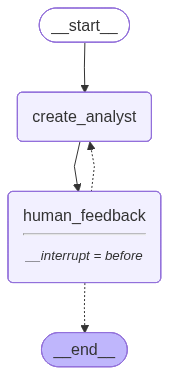

In [69]:
graph

In [70]:
topic="the benefits of adopting Langgraph as an agent framework"

In [71]:
max_analysts=4

In [72]:
thread={"configurable":{"thread_id":1}}

In [73]:
for event in graph.stream({"topic":topic,
              "max_analysts":max_analysts},
             thread,
             stream_mode= "values"):
    analysts = event.get('analysts', '')
    
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Name: Dr. Maya Patel
Affiliation: Institute for Scalable AI Systems
Role: Scalability & Performance Analyst
Description: Focuses on how Langgraph's graph-based execution model enables horizontal scaling, low-latency agent orchestration, and efficient resource utilization. Concerned with performance benchmarks, concurrency handling, and real-time responsiveness in production deployments.
--------------------------------------------------
Name: Alex Chen
Affiliation: OpenAI Developer Relations
Role: Developer Experience & Composability Analyst
Description: Examines the ergonomics of building agents with Langgraph, including its declarative API, modular node design, and debugging tooling. Advocates for rapid prototyping, maintainable codebases, and lower barrier to entry for LLM‑centric developers.
--------------------------------------------------
Name: Priya Singh
Affiliation: AI Integration Lab, Stanford University
Role: Ecosystem Integration Analyst
Description: Analyzes Langgraph's c

In [74]:
state= graph.get_state(thread)

In [75]:
state

StateSnapshot(values={'topic': 'the benefits of adopting Langgraph as an agent framework', 'max_analysts': 4, 'analysts': [Analyst(name='Dr. Maya Patel', role='Scalability & Performance Analyst', affiliation='Institute for Scalable AI Systems', description="Focuses on how Langgraph's graph-based execution model enables horizontal scaling, low-latency agent orchestration, and efficient resource utilization. Concerned with performance benchmarks, concurrency handling, and real-time responsiveness in production deployments."), Analyst(name='Alex Chen', role='Developer Experience & Composability Analyst', affiliation='OpenAI Developer Relations', description='Examines the ergonomics of building agents with Langgraph, including its declarative API, modular node design, and debugging tooling. Advocates for rapid prototyping, maintainable codebases, and lower barrier to entry for LLM‑centric developers.'), Analyst(name='Priya Singh', role='Ecosystem Integration Analyst', affiliation='AI Integ

In [76]:
state.values

{'topic': 'the benefits of adopting Langgraph as an agent framework',
 'max_analysts': 4,
 'analysts': [Analyst(name='Dr. Maya Patel', role='Scalability & Performance Analyst', affiliation='Institute for Scalable AI Systems', description="Focuses on how Langgraph's graph-based execution model enables horizontal scaling, low-latency agent orchestration, and efficient resource utilization. Concerned with performance benchmarks, concurrency handling, and real-time responsiveness in production deployments."),
  Analyst(name='Alex Chen', role='Developer Experience & Composability Analyst', affiliation='OpenAI Developer Relations', description='Examines the ergonomics of building agents with Langgraph, including its declarative API, modular node design, and debugging tooling. Advocates for rapid prototyping, maintainable codebases, and lower barrier to entry for LLM‑centric developers.'),
  Analyst(name='Priya Singh', role='Ecosystem Integration Analyst', affiliation='AI Integration Lab, Sta

In [77]:
state.next

('human_feedback',)

In [78]:
memory.storage.items()

dict_items([('1', defaultdict(<class 'dict'>, {'': {'1f0db649-4a89-6ebc-bfff-c93a734c0e57': (('msgpack', b'\x86\xa1v\x04\xa2ts\xd9 2025-12-17T16:22:28.577657+00:00\xa2id\xd9$1f0db649-4a89-6ebc-bfff-c93a734c0e57\xb0channel_versions\x81\xa9__start__\xd9300000000000000000000000000000001.0.9190792589920158\xadversions_seen\x81\xa9__input__\x80\xb0updated_channels\x91\xa9__start__'), ('msgpack', b'\x83\xa6source\xa5input\xa4step\xff\xa7parents\x80'), None), '1f0db649-4a96-60a5-8000-768ad20c372d': (('msgpack', b'\x86\xa1v\x04\xa2ts\xd9 2025-12-17T16:22:28.582621+00:00\xa2id\xd9$1f0db649-4a96-60a5-8000-768ad20c372d\xb0channel_versions\x84\xa9__start__\xd9300000000000000000000000000000002.0.8474323445008204\xa5topic\xd9300000000000000000000000000000002.0.8474323445008204\xacmax_analysts\xd9300000000000000000000000000000002.0.8474323445008204\xb8branch:to:create_analyst\xd9300000000000000000000000000000002.0.8474323445008204\xadversions_seen\x82\xa9__input__\x80\xa9__start__\x81\xa9__start__\xd

In [79]:
state.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0db649-5dc9-64b7-8001-0de7933b4303'}}

In [80]:
graph.update_state(thread,
                   {"human_analyst_feedback": "Add something from the startup perspective and focus on the lastest enterprise application"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0db649-9bc2-6131-8002-d874a114bf88'}}

In [81]:
for event in graph.stream({"topic":topic,
              "max_analysts":max_analysts},
             thread,
             stream_mode= "values"):
    analysts = event.get('analysts', '')
    
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Maya Patel
Affiliation: Institute for Scalable AI Systems
Role: Scalability & Performance Analyst
Description: Focuses on how Langgraph's graph-based execution model enables horizontal scaling, low-latency agent orchestration, and efficient resource utilization. Concerned with performance benchmarks, concurrency handling, and real-time responsiveness in production deployments.
--------------------------------------------------
Name: Alex Chen
Affiliation: OpenAI Developer Relations
Role: Developer Experience & Composability Analyst
Description: Examines the ergonomics of building agents with Langgraph, including its declarative API, modular node design, and debugging tooling. Advocates for rapid prototyping, maintainable codebases, and lower barrier to entry for LLM‑centric developers.
--------------------------------------------------
Name: Priya Singh
Affiliation: AI Integration Lab, Stanford University
Role: Ecosystem Integration Analyst
Description: Analyzes Langgraph's c

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Name: Dr. Maya Patel
Affiliation: GlobalTech Solutions (Enterprise AI Division)
Role: Enterprise Scalability Analyst
Description: Focuses on how Langgraph scales for large, mission‑critical workloads, evaluating performance, fault tolerance, and multi‑tenant capabilities. Concerned with meeting SLA requirements and ensuring the framework can handle high‑throughput, low‑latency enterprise applications.
--------------------------------------------------
Name: Liam Chen
Affiliation: LaunchPad AI (Seed‑stage startup accelerator)
Role: Startup Innovation Analyst
Description: Examines Langgraph from a lean‑startup perspective, emphasizing rapid prototyping, low entry barriers, and flexibility for building MVPs. Motivated by speed to market, developer experience, and the ability to iterate quickly on agent‑based products.
--------------------------------------------------
Name: Sofia García
Affiliation: IntegrateX Consulting
Role: Enterprise Integration Specialist
Description: Analyzes how La

In [82]:
state= graph.get_state(thread)

In [83]:
state

StateSnapshot(values={'topic': 'the benefits of adopting Langgraph as an agent framework', 'max_analysts': 4, 'human_analyst_feedback': 'Add something from the startup perspective and focus on the lastest enterprise application', 'analysts': [Analyst(name='Dr. Maya Patel', role='Enterprise Scalability Analyst', affiliation='GlobalTech Solutions (Enterprise AI Division)', description='Focuses on how Langgraph scales for large, mission‑critical workloads, evaluating performance, fault tolerance, and multi‑tenant capabilities. Concerned with meeting SLA requirements and ensuring the framework can handle high‑throughput, low‑latency enterprise applications.'), Analyst(name='Liam Chen', role='Startup Innovation Analyst', affiliation='LaunchPad AI (Seed‑stage startup accelerator)', description='Examines Langgraph from a lean‑startup perspective, emphasizing rapid prototyping, low entry barriers, and flexibility for building MVPs. Motivated by speed to market, developer experience, and the ab

In [84]:
state.next

('human_feedback',)

In [85]:
state.values

{'topic': 'the benefits of adopting Langgraph as an agent framework',
 'max_analysts': 4,
 'human_analyst_feedback': 'Add something from the startup perspective and focus on the lastest enterprise application',
 'analysts': [Analyst(name='Dr. Maya Patel', role='Enterprise Scalability Analyst', affiliation='GlobalTech Solutions (Enterprise AI Division)', description='Focuses on how Langgraph scales for large, mission‑critical workloads, evaluating performance, fault tolerance, and multi‑tenant capabilities. Concerned with meeting SLA requirements and ensuring the framework can handle high‑throughput, low‑latency enterprise applications.'),
  Analyst(name='Liam Chen', role='Startup Innovation Analyst', affiliation='LaunchPad AI (Seed‑stage startup accelerator)', description='Examines Langgraph from a lean‑startup perspective, emphasizing rapid prototyping, low entry barriers, and flexibility for building MVPs. Motivated by speed to market, developer experience, and the ability to iterate

In [86]:
# If we are satisfied, then simply supply no feedback
further_feedback=""

In [87]:
# 1. Get the latest state
state= graph.get_state(thread)

# 2. Use the exact config from that state (if already has thread_id, checkpoint_ns, checkpoint_id)
cfg= state.config

# 3. Update the feedback at the "human_feedback" node
#        Tip: if your TypedDict says 'human_analyst_feedback: str', prefer empty string "" over None
graph.update_state(cfg, {'human_analyst_feedback': ""}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0db649-e53f-66c5-8006-2596efacc15e'}}

In [88]:
# 4. Verify it moved to END
final_state= graph.get_state(thread)
print(final_state.next)

()


In [89]:
analysts

[Analyst(name='Dr. Maya Patel', role='Enterprise Scalability Analyst', affiliation='GlobalTech Solutions (Enterprise AI Division)', description='Focuses on how Langgraph scales for large, mission‑critical workloads, evaluating performance, fault tolerance, and multi‑tenant capabilities. Concerned with meeting SLA requirements and ensuring the framework can handle high‑throughput, low‑latency enterprise applications.'),
 Analyst(name='Liam Chen', role='Startup Innovation Analyst', affiliation='LaunchPad AI (Seed‑stage startup accelerator)', description='Examines Langgraph from a lean‑startup perspective, emphasizing rapid prototyping, low entry barriers, and flexibility for building MVPs. Motivated by speed to market, developer experience, and the ability to iterate quickly on agent‑based products.'),
 Analyst(name='Sofia García', role='Enterprise Integration Specialist', affiliation='IntegrateX Consulting', description='Analyzes how Langgraph plugs into existing enterprise ecosystems—E

In [90]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Dr. Maya Patel
Affiliation: GlobalTech Solutions (Enterprise AI Division)
Role: Enterprise Scalability Analyst
Description: Focuses on how Langgraph scales for large, mission‑critical workloads, evaluating performance, fault tolerance, and multi‑tenant capabilities. Concerned with meeting SLA requirements and ensuring the framework can handle high‑throughput, low‑latency enterprise applications.
--------------------------------------------------
Name: Liam Chen
Affiliation: LaunchPad AI (Seed‑stage startup accelerator)
Role: Startup Innovation Analyst
Description: Examines Langgraph from a lean‑startup perspective, emphasizing rapid prototyping, low entry barriers, and flexibility for building MVPs. Motivated by speed to market, developer experience, and the ability to iterate quickly on agent‑based products.
--------------------------------------------------
Name: Sofia García
Affiliation: IntegrateX Consulting
Role: Enterprise Integration Specialist
Description: Analyzes how La

In [91]:
from langchain_community.document_loaders import WikipediaLoader
docs= WikipediaLoader(query="AWS").load()
print(docs[0].page_content[:500])

c:\Users\birok\Python\LLMOPs\research-report-generation\venv\Lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\birok\Python\LLMOPs\research-report-generation\venv\Lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Amazon Web Services, Inc. (AWS) is a subsidiary of Amazon that provides on-demand cloud computing platforms and APIs to individuals, companies, and governments, on a metered, pay-as-you-go basis.
Clients often use this in combination with autoscaling (a process that allows a client to use more computing in times of high application usage, and then scale down to reduce costs when there is less traffic). These cloud computing web services provide various services related to networking, compute, st


In [92]:
from langchain_community.utilities import WikipediaAPIWrapper
wiki = WikipediaAPIWrapper(doc_content_chars_max=4000)
docs = wiki.run("The benefits of adopting LangGraph as an agentic framework")
print(docs)

Page: Semantic Web
Summary: The Semantic Web, sometimes known as Web 3.0, is an extension of the World Wide Web through standards set by the World Wide Web Consortium (W3C). The goal of the Semantic Web is to make Internet data machine-readable.
To enable the encoding of semantics with the data, technologies such as Resource Description Framework (RDF) and Web Ontology Language (OWL) are used. These technologies are used to formally represent metadata. For example, ontology can describe concepts, relationships between entities, and categories of things. These embedded semantics offer significant advantages such as reasoning over data and operating with heterogeneous data sources.
These standards promote common data formats and exchange protocols on the Web, fundamentally the RDF. According to the W3C, "The Semantic Web provides a common framework that allows data to be shared and reused across application, enterprise, and community boundaries." The Semantic Web is therefore regarded as

## Second Workflow

In [93]:
from langchain_community.tools.tavily_search import TavilySearchResults

In [94]:
from dotenv import load_dotenv
load_dotenv()
import os
tavily_api_key= os.getenv("TAVILY_API_KEY")

In [95]:
tavily_search= TavilySearchResults(tavily_api_key=tavily_api_key)

C:\Users\birok\AppData\Local\Temp\ipykernel_11076\2693776339.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_search= TavilySearchResults(tavily_api_key=tavily_api_key)


In [96]:
tavily_search.invoke("langgraph")

[{'title': 'LangGraph overview - Docs by LangChain',
  'url': 'https://docs.langchain.com/oss/javascript/langgraph/overview',
  'content': 'Trusted by companies shaping the future of agents— including Klarna, Replit, Elastic, and more— LangGraph is a low-level orchestration framework and runtime for building, managing, and deploying long-running, stateful agents.LangGraph is very low-level, and focused entirely on agent orchestration. Before using LangGraph, we recommend you familiarize yourself with some of the components used to build agents, starting with models and tools.We will commonly use LangChain components throughout the [...] \u200b\n\nAcknowledgements\n\nLangGraph is inspired by Pregel and Apache Beam. The public interface draws inspiration from NetworkX. LangGraph is built by LangChain Inc, the creators of LangChain, but can be used without LangChain.\n\n  \n\nEdit the source of this page on GitHub.\n\nConnect these docs programmatically to Claude, VSCode, and more via MCP

In [97]:
from langchain_community.document_loaders import WikipediaLoader
docs= WikipediaLoader(query="Langgraph").load()
print(docs[0].page_content[:500])

LangChain is a software framework that helps facilitate the integration of large language models (LLMs) into applications. As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.


== History ==
LangChain was launched in October 2022 as an open source project by Harrison Chase, while working at machine learning startup Robust Intelligence. In April 2023, 


In [98]:
import operator
from typing import Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int #Number turns of conversation
    context: Annotated[List, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for send() API

class SearchQuery(BaseModel):
    search_query: str= Field(None, description="search query for retrieval.")

In [99]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

In [100]:
print(analyst.persona)

Name: Rajiv Menon
Role: Cost‑Efficiency & Operations Analyst
Affiliation: FinOps Labs (Financial Operations Research Group)
Description: Evaluates the total cost of ownership when adopting Langgraph, including infrastructure spend, developer productivity gains, and operational overhead. Focuses on ROI, budgeting, and sustainable scaling for both startups and large enterprises.



In [101]:
question_instructions.format(goals= analyst.persona)

'You are an analyst tasked with interviewing an expert to learn about a specific topic. \n\nYour goal is boil down to interesting and specific insights related to your topic.\n\n1. Interesting: Insights that people will find surprising or non-obvious.\n\n2. Specific: Insights that avoid generalities and include specific examples from the expert.\n\nHere is your topic of focus and set of goals: Name: Rajiv Menon\nRole: Cost‑Efficiency & Operations Analyst\nAffiliation: FinOps Labs (Financial Operations Research Group)\nDescription: Evaluates the total cost of ownership when adopting Langgraph, including infrastructure spend, developer productivity gains, and operational overhead. Focuses on ROI, budgeting, and sustainable scaling for both startups and large enterprises.\n\n\nBegin by introducing yourself using a name that fits your persona, and then ask your question.\n\nContinue to ask questions to drill down and refine your understanding of the topic.\n\nWhen you are satisfied with yo

In [102]:
def generation_question(state: InterviewState):
    """Node to generate the questions"""

    #get state
    analyst=state["analyst"]
    messages= state["messages"]

    #generate the question
    system_message= question_instructions.format(goals=analyst.persona)
    question= llm.invoke([SystemMessage(content=system_message)]+messages)

    #Return the question state
    return {"messages":[question]}

In [103]:
analyst

Analyst(name='Rajiv Menon', role='Cost‑Efficiency & Operations Analyst', affiliation='FinOps Labs (Financial Operations Research Group)', description='Evaluates the total cost of ownership when adopting Langgraph, including infrastructure spend, developer productivity gains, and operational overhead. Focuses on ROI, budgeting, and sustainable scaling for both startups and large enterprises.')

In [104]:
state= {"max_num_turns":2, "context":[], "analyst":analyst, "interview":"", "section":[], "messages":[HumanMessage(content="Please do the proper search according to the expertise.")]}

In [105]:
state

{'max_num_turns': 2,
 'context': [],
 'analyst': Analyst(name='Rajiv Menon', role='Cost‑Efficiency & Operations Analyst', affiliation='FinOps Labs (Financial Operations Research Group)', description='Evaluates the total cost of ownership when adopting Langgraph, including infrastructure spend, developer productivity gains, and operational overhead. Focuses on ROI, budgeting, and sustainable scaling for both startups and large enterprises.'),
 'interview': '',
 'section': [],
 'messages': [HumanMessage(content='Please do the proper search according to the expertise.', additional_kwargs={}, response_metadata={})]}

In [106]:
result= generation_question(state)

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


In [107]:
print(result["messages"][0].content)

**Interviewer (Aisha Patel, FinOps Analyst & Researcher):**  
Hi Rajiv, thank you for taking the time to speak with me. I’m looking to understand the total cost of ownership (TCO) when a company adopts **Langgraph**—from infrastructure spend to developer productivity gains and ongoing operational overhead. Could you start by giving a high‑level overview of the primary cost components you consider when evaluating Langgraph for a mid‑size SaaS startup?


In [108]:
from langchain_core.messages import get_buffer_string

In [109]:
# Search query writing
search_instructions= SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 
Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation. 
First, analyze the full conversation.
Pay particular attention to the final question posed by the analyst.
Convert this final question into a well-structured web search query""")

In [110]:
def search_web(state:InterviewState):
    """
    Retrieve data from the web
    """
    structure_llm = llm.with_structured_output(SearchQuery)
    search_query = structure_llm.invoke([search_instructions]+state["messages"])
    
    # Search
    search_docs = tavily_search.invoke(search_query.search_query)
    # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

In [111]:
state = {"max_num_turns":2,"context":[],"analyst":analyst,"interview":"","section":[],
         'messages': [AIMessage(content="Hello, my name is Alex Thompson, and I'm an analyst interested in understanding the strategic implications of adopting Langgraph for businesses. I'm particularly keen on how this framework can drive innovation and support digital transformation initiatives. Thank you for taking the time to speak with me today, Michael. \n\nTo start, could you explain what Langgraph is and why it's becoming a significant consideration for businesses looking to innovate?")
         ]
}

In [166]:

result = search_web(state)

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


In [ ]:
print(result["context"][0])

<Document href="https://latenode.com/blog/ai-frameworks-technical-infrastructure/langgraph-multi-agent-orchestration/langgraph-multi-agent-systems-complete-tutorial-examples"/>
LangGraph is a framework enabling multiple AI agents to collaborate on complex tasks by dividing responsibilities into specialized roles. This approach improves task efficiency, error management, and resource allocation. By leveraging LangGraph, businesses can automate workflows like customer support, content creation, and data processing. For example, a customer service system might classify inquiries, retrieve relevant data, and craft responses using different agents, all working together
</Document>

---

<Document href="https://www.linkedin.com/pulse/understanding-langgraph-its-role-enterprise-agentic-aisystems-ehsan-rbbkf"/>
At its core, LangGraph allows developers to define and execute intelligent workflows using a graph-based model, where every computation or decision is represented as a node and the sequ

In [113]:
def search_wikipedia(state: InterviewState):
    """
    Retrieve data from wiki
    """
    # Extract topic directly from the last message
    last_message = state['messages'][-1].content if state['messages'] else ""
    
    # Use LLM to generate query as plain text
    query_prompt = f"{search_instructions}\n\nConversation: {last_message}\n\nGenerate only the search query:"
    response = llm.invoke(query_prompt)
    search_query_text = response.content.strip()
    
    print("*******************************")
    print(f"Search query: {search_query_text}")
    
    # Search
    search_docs = WikipediaLoader(query=search_query_text).load()

    # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

In [114]:
state = {"max_num_turns":2,"context":[],"analyst":analyst,"interview":"","section":[],
         'messages': [AIMessage(content="Hello, my name is Alex Thompson, and I'm an analyst interested in understanding the strategic implications of adopting Langgraph for businesses. I'm particularly keen on how this framework can drive innovation and support digital transformation initiatives. Thank you for taking the time to speak with me today, Michael. \n\nTo start, could you explain what Langgraph is and why it's becoming a significant consideration for businesses looking to innovate?")
         ]
}

In [115]:
result= search_wikipedia(state)

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
Search query: Langgraph definition and business significance for innovation and digital transformation strategies


In [116]:
answer_instructions = """You are an expert being interviewed by an analyst.
Here is analyst area of focus: {goals}.      
You goal is to answer a question posed by the interviewer.
To answer question, use this context:      
{context}
When answering questions, follow these guidelines:      
1. Use only the information provided in the context.        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.
3. The context contain sources at the topic of each individual document.
4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1].
5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list:   
[1] assistant/docs/llama3_1.pdf, page 7   
And skip the addition of the brackets as well as the Document source preamble in your citation."""

In [117]:
def generate_answer(state: InterviewState):
    """
    Node to answer a question
    """
    # Get state
    analyst= state["analyst"]
    messages=state["messages"]
    context=state["context"]

    #Answer question
    system_message= answer_instructions.format(goals=analyst.persona, context=context)
    answer= llm.invoke([SystemMessage(content=system_message)]+messages)

    # Name the message as coming from th expert
    answer.name="expert"

    #Append it to the state
    return {"messages": [answer]}

In [118]:
def route_messages(state: InterviewState, name:str="expert"):
    """Route between question and answer"""

    #Get messages
    messages=state["messages"]
    max_num_turns= state.get('max_num_turns', 2)

    # Check the number of expert answers
    num_responses= len(
        [m for m in messages if isinstance(m, AIMessage) and m.name==name]
    )

    # End if expert has answered more than the max turns
    if num_responses>= max_num_turns:
        return 'save_interview'
    
    # This router is run after each question - answer pair
    # Get the last question asked to check if it signals the end of discussion
    last_question=messages[-2]

    if "Thank you so much for your help" in last_question.content:
        return "save_interview"
    
    return "ask_question"

In [119]:
def save_interview(state: InterviewState):
    """ Save Interviews"""
    # Get messages
    messages=state["messages"]

    # Convert interview to a string
    interview= get_buffer_string(messages)

    #Save to interviews key
    return {'interview': interview}

In [120]:
section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

In [121]:
def write_section(state: InterviewState):
    """Node to answer a question"""

    #Get state
    interview=state["interview"]
    context=state["context"]
    analyst= state["analyst"]
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message= section_writer_instructions.format(focus=analyst.description)
    section= llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write this section: {context}")])

    # Append it to state
    return {"sections":[section.content]}

In [157]:
interview_builder= StateGraph(InterviewState)

In [158]:
interview_builder.add_node("ask_question", generation_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("generate_answer", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

In [159]:
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("search_web", "generate_answer")
interview_builder.add_edge("search_wikipedia", "generate_answer")
interview_builder.add_conditional_edges("generate_answer",
                                        route_messages,
                                        ["ask_question",
                                         "save_interview"])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

In [167]:
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name = "Conduct Interview")

In [169]:
interview_graph

ValueError: Failed to reach https://mermaid.ink API while trying to render your graph. Status code: 204.

To resolve this issue:
1. Check your internet connection and try again
2. Try with higher retry settings: `draw_mermaid_png(..., max_retries=5, retry_delay=2.0)`
3. Use the Pyppeteer rendering method which will render your graph locally in a browser: `draw_mermaid_png(..., draw_method=MermaidDrawMethod.PYPPETEER)`

In [127]:
analyst.persona

'Name: Rajiv Menon\nRole: Cost‑Efficiency & Operations Analyst\nAffiliation: FinOps Labs (Financial Operations Research Group)\nDescription: Evaluates the total cost of ownership when adopting Langgraph, including infrastructure spend, developer productivity gains, and operational overhead. Focuses on ROI, budgeting, and sustainable scaling for both startups and large enterprises.\n'

In [128]:
thread= {"configurable":{"thread_id": "1"}}

In [129]:
messages= [HumanMessage("So you said you were writing an article on Langchain?")]

In [130]:
interview = interview_graph.invoke({"analyst": analyst, "messages": messages, "max_num_turns": 2}, thread)

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
Search query: Langgraph migration from Langchain cost comparison case study compute‑hour reduction memory footprint cloud‑provider expense analysis


HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
Search query: LangChain to LangGraph migration case study compute hours GPU vCPU memory cost savings cloud bill developer productivity gains pull‑request velocity on‑call incidents operational overhead engineering hours saved ROI timeline SaaS chatbot 


HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
Retrying request to /openai/v1/chat/completions in 8.000000 seconds
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
Retrying request to /openai/v1/chat/completions in 15.000000 seconds
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


In [122]:
from IPython.display import Markdown

In [123]:
Markdown(interview["sections"][0])

## LangGraph ROI: Turning Developer‑Hour Savings into Real‑World Cost Efficiency for Startups and Enterprises  

### Summary  
AI‑agent frameworks such as LangGraph promise faster product cycles, but the true business impact hinges on licensing, cloud spend, and the hidden operational load of running agents at scale.  

1. **Massive productivity gains** – Uber’s engineering team reported a **21,000‑hour reduction** after adopting “intentional tech transfer” and “super‑capable domain‑expert agents” built with LangGraph [1]. This translates to roughly **$2.5 M** in saved labor (assuming $120 / hour), a headline ROI that even large enterprises can replicate.  

2. **Hidden engineering costs** – Although LangGraph’s core library is MIT‑licensed and free to download, real‑world deployments routinely require **14+ weeks and $87 k** of developer effort for a modest e‑commerce support agent [2]. The bulk of the expense comes from debugging, state‑persistence, and cloud infrastructure rather than the software itself.  

3. **Operational overhead of self‑hosting** – Running LangGraph Server demands managed Redis/PostgreSQL clusters, logging pipelines, and custom scaling logic. Teams that attempted a DIY deployment found themselves spending **45‑48 % more operational time** than with a managed service, equating to **$78 k–$325 k / year** for a five‑engineer squad [5][6].  

4. **Managed platforms accelerate velocity** – LangChain’s “LangSmith Deployment” service (cloud, hybrid, or self‑hosted) bundles state management, streaming, and error handling, letting teams ship agents in days instead of months. Cisco’s Outshift platform reported a **10× productivity boost**, cutting CI/CD pipeline setup from a week to under an hour [4].  

5. **Cost‑structure comparison** – Open‑source stacks still incur LLM API fees (≈ $50–$200 / month for small projects, $500–$2 000 / month for medium workloads) [3]. Enterprise‑grade graph back‑ends (e.g., TigerGraph) add **thousands to tens of thousands** of dollars monthly for dedicated support [3]. Managed SaaS alternatives typically bundle these expenses into a predictable subscription, reducing surprise spend.  

6. **Strategic trade‑offs for startups vs. enterprises** – Startups benefit most from the **speed‑to‑market** of managed LangGraph services, avoiding the steep upfront engineering outlay. Large enterprises, while capable of absorbing operational complexity, often achieve higher ROI by off‑loading DevOps to a managed layer, freeing senior engineers to focus on domain‑specific agent logic and business outcomes.  

Overall, the data suggest that **the headline “free” label of LangGraph is misleading**; true cost efficiency emerges only when organizations pair the open‑source core with a managed hosting or platform layer that curtails hidden engineering and operational expenses. When this balance is struck, the dramatic developer‑hour savings reported by industry leaders become a tangible, repeatable ROI driver across both startups and Fortune‑500 firms.  

### Sources  
[1] https://www.linkedin.com/posts/langchain_how-uber-used-langgraph-to-build-ai-developer-activity-7338259737395781634-QJ5d  
[2] https://agentiveaiq.com/blog/is-langgraph-free-how-agentiveaiq-beats-open-source  
[3] https://www.leanware.co/insights/langchain-vs-tigergraph-comparison  
[4] https://blog.langchain.com/tag/case-studies/  
[5] https://community.latenode.com/t/understanding-langgraph-server-deployment-costs-and-self-hosting-options/33992  
[6] https://strapi.io/blog/self-hosting-vs-managed-hosting  
[7] https://fin.ai/research/cost-of-serving-llms/  
[8] https://www.qovery.com/blog/self-hosted-vs-fully-managed-hosting  
[9] https://www.langchain.com/pricing

## Third Workflow

In [177]:
from typing_extensions import TypedDict
from typing import List, Annotated
import operator
class ResearchGraphState(TypedDict):
    topic: str #Research Topic
    max_analysts: int #Number of Analsyt
    human_analyst_feedback: str # Human Feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str #Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str #Final Report

In [178]:
from langgraph.types import Send

In [179]:
def initiate_all_interviews(state: ResearchGraphState):
    """This is the 'map' step where we run each interview sub-graph using Send API"""

    #Check if human feedback
    human_analyst_feedback= state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create analysts
        return "create_analyst"
    # Otherwise kick-off interview in parallel via Send() API
    else:
        topic= state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,
                                           "messages":[HumanMessage(
                                               content=f"So you said you were writing an article on {topic}?"
                                           )]})for analyst in state["analysts"]]

In [134]:
report_writer_instructions="""You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""

In [135]:
def write_report(state: ResearchGraphState):
    # Full set of sections
    sections= state["sections"]
    topic= state["topic"]
    #Concat all sections together
    formatted_str_sections= "\n\n".join([f"{section}" for section in sections])

    #Summarize the sections into a final report
    system_message= report_writer_instructions.format(topic=topic, context=formatted_str_sections)
    report= llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based onn these memos.")])
    return {"content": report.content}


In [136]:
intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}
You will be given all of the sections of the report.
You job is to write a crisp and compelling introduction or conclusion section.
The user will instruct you whether to write the introduction or conclusion.
Include no pre-amble for either section.
Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.
Use markdown formatting. 
For your introduction, create a compelling title and use the # header for the title.
For your introduction, use ## Introduction as the section header.
For your conclusion, use ## Conclusion as the section header.
Here are the sections to reflect on for writing: {formatted_str_sections}"""

In [137]:
def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections=state["sections"]
    topic= state["topic"]

    # Concat all sections together
    formatted_str_sections= "\n\n".join([f"{sections}" for section in sections])

    #Summarise the sections into a final report
    instructions= intro_conclusion_instructions(topic=topic, formatted_str_sections=formatted_str_sections)
    intro= llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")])
    return {"introduction": intro.content}

In [138]:
def write_conclusion(state: ResearchGraphState):
     # Full set of sections
    sections=state["sections"]
    topic= state["topic"]

    # Concat all sections together
    formatted_str_sections= "\n\n".join([f"{sections}" for section in sections])

    #Summarise the sections into a final report
    instructions= intro_conclusion_instructions(topic=topic, formatted_str_sections=formatted_str_sections)
    conclusion= llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")])
    return {"conclusion": conclusion.content}

In [139]:
def finalize_report(state: ResearchGraphState):
    """"The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save the final report
    content= state["content"]
    if content.startswith("## Insights"):
        content= content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources= content.split("\n## Sources \n")
        except:
            sources = None
    else:
        sources=None
    final_report= state["introduction"]+"\n\n---\n\n"+content+"\n\n---\n\n"+state["conclusion"]
    if sources is not None:
        final_report+= "\n\n## Sources\n"+sources
    return {"final_report": final_report}

In [180]:
# Add nodes and edges
builder= StateGraph(ResearchGraphState)
builder.add_node("create_analyst", create_analyst)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report", write_report)
builder.add_node("write_introduction", write_introduction)
builder.add_node("write_conclusion", write_conclusion)
builder.add_node("finalize_report", finalize_report)

#Logic
builder.add_edge(START, "create_analyst")
builder.add_edge("create_analyst", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analyst", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

In [181]:
builder

In [182]:
memory=MemorySaver()

In [183]:
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

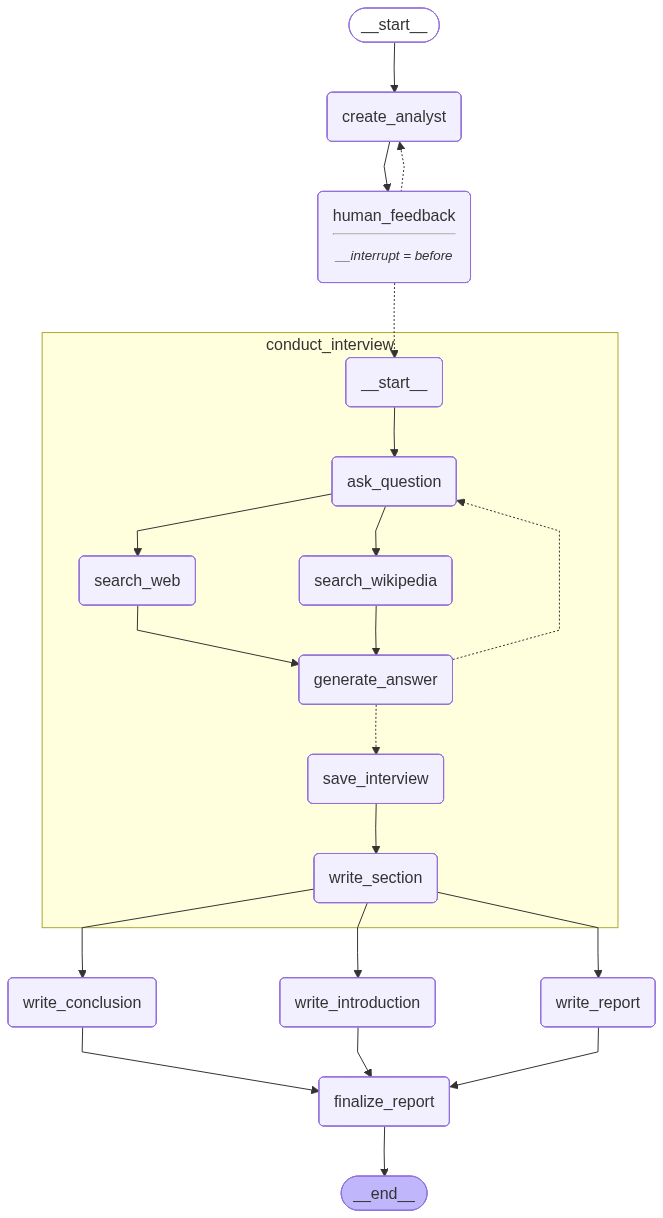

In [184]:

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [185]:
max_analysts=3

In [186]:
topic= "How can Generative AI accelerate drug discovery?"

In [187]:
thread= {"configurable":{"thread_id":"1"}}

In [188]:
# Run the graph untill the first interruption
for event in graph.stream({"topic": topic, "max_analysts":max_analysts}, thread, stream_mode="values"):
    analysts= event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-"*50)

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Name: Dr. Maya Patel
Affiliation: Institute for Computational Chemistry, Stanford University
Role: Generative Molecular Design Lead
Description: Focuses on using large language models and diffusion-based generative AI to explore novel chemical space, design de novo drug candidates, and optimize molecular properties such as potency, selectivity, and synthetic accessibility.
--------------------------------------------------
Name: Dr. Luis Gómez
Affiliation: PharmaAI Lab, Novartis Institutes for BioMedical Research
Role: Predictive ADMET & Efficacy Analyst
Description: Specializes in AI-driven prediction of absorption, distribution, metabolism, excretion, and toxicity (ADMET) as well as efficacy modeling, integrating generative outputs with multi‑task deep learning to prioritize safe and effective drug candidates.
--------------------------------------------------
Name: Dr. Elena Rossi
Affiliation: Center for Digital Therapeutics, European Molecular Biology Laboratory (EMBL)
Role: AI‑Ena

In [189]:
graph.update_state(thread, {"human_analyst_feedback":""}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0db68a-c358-68db-8002-0d8079079cb1'}}

In [190]:
graph.get_state(thread).next

('conduct_interview', 'conduct_interview', 'conduct_interview')

In [191]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name=next(iter(event.keys()))
    print(node_name)

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
Search query: EMBL generative AI high‑throughput screening workflow impact timeline from target identification to pre‑clinical candidate


HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
Search query: generative AI drug discovery surprising candidate missed by traditional chemistry 2023-2024 target scaffold ADMET predictions example


HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
Search query: large‑language‑model guided diffusion generator drug discovery recent project target molecular scaffold experimental validation Stanford


HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
Retrying request to /openai/v1/chat/completions in 10.000000 seconds
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
Retrying request to /openai/v1/chat/completions in 9.000000 seconds
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
Retrying request to /openai/v1/chat/completions in 12.000000 seconds
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
Retrying request to /openai/v1/chat/completions in 7.000000 seconds
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
Retrying request to /openai/v1/chat/completions in 1.000

*******************************
Search query: integrating protein‑protein interaction modulators and RNA‑targeting small molecules into AI‑driven closed‑loop drug discovery pipelines – required modifications to the generative AI workflow and data integration strategies.


HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
Retrying request to /openai/v1/chat/completions in 5.000000 seconds
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
Retrying request to /openai/v1/chat/completions in 29.000000 seconds
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
Retrying request to /openai/v1/chat/completions in 25.000000 seconds
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for model `openai/gpt-oss-120b` in organization `org_01j7x4dxzze878mnfyp6q4ka2f` service tier `on_demand` on tokens per minute (TPM): Limit 8000, Used 7575, Requested 1795. Please try again in 10.275s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}